# Trabalho 3: transformação de Levi-Civita

Luan Henrique Glasser

Professor Hélio Kuga

02/09/2021

---

## Problema

Considere o exercício 4 da Lista 00:

> **Lista 00 - Exercício 4**
>
>Considere a seguinte EDO de Segunda ordem:
>
> $\ddot{r} = - \mu \frac{r}{r^3}$
>
>em que 3,986e5 $km^3/s^2$ é a constante geogravitacional, e **r** = [x, y] é o vetor posição. As condições iniciais de posição e velocidade para o instante $t_0 = 0$ segundos, são 
>
>$x_0$ = 7000 $km$, $\dot{x}_0$ = 0 $km/s$,
>
>$y_0$ = 0 $km$ e $\dot{y}_0$ = 7,546049108166282 $km/s$.
>
>Obtenha os resultados usando os métodos de RK4 e ABM de ordem 4, para o intervalo $t$ = [0 $T$] segundos, em que $T=$  5828,519867788797 $s$ é o período desta trajetória, e compare com a solução analítica exata, na forma da tabela abaixo.
>Descreva claramente qual o passo de integração utilizado e a razão dessa escolha.

Use a transformação de Levi-Civita (LC) e integre as EDO-s correspondentes (10?), usando Runge-Kutta de ordem 4 (RK4), e Preditor-Corretor de Adams-Bashforth-Moulton (ABM) de ordem 4 (PC4), para o intervalo t = [0, T] segundos, em que T = 5828,519867788797 segundos. Compare os resultados com os da Lista 00, e com o uso da transformação de LC. Tire algumas conclusões.

---

## Preparo

Esta seção serve para importar bibliotecas e trazer de outros trabalhos as classes de integradores numéricos. Tanto as bibliotecas quanto os integradores são essenciais à solução do problema proposto neste trabalho. 

### Bibliotecas



In [20]:
# Importar bibliotecas.
import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    

from math import *

### Classes de integradores

A seguir, a classe dos integradores Runge-Kutta (RK) será criada.

In [21]:
# Importar classe de integradores Runge-Kutta.
class RungeKutta:
    '''
    Classe RungeKutta
    ---
    Contém Runge-Kuttas de 2a, 3a e 4a ordem.
    '''
        
    # Função do Runge-Kutta 2
    def rk2(self, eq, t, x, h):
        '''
        Esta função executa 1 passo do Runge-Kutta de 2a ordem
        ---
        Entradas: 
            eq - função com a equação a ser resolvida, deve seguir o formato eq(t, x);
            t - tempo atual de integração; 
            x - estado atual; 
            h - passo de integração.
        Retorna o próxio estado integrado.
        '''
        k1 = eq(t, x)
        k2 = eq(t + h, x + h*k1)
        x = x + (h/2)*(k1 + k2)
        return x    

    # Função do Runge-Kutta 3
    def rk3(self, eq, t, x, h):
        '''
        Esta função executa 1 passo do Runge-Kutta de 3a ordem
        ---
        Entradas: 
            eq - função com a equação a ser resolvida, deve seguir o formato eq(t, x);
            t - tempo atual de integração; 
            x - estado atual; 
            h - passo de integração.
        Retorna o próxio estado integrado.
        '''
        k1 = eq(t, x)
        k2 = eq(t + (2/3)*h, x + (2/3)*h*k1)
        k3 = eq(t + (2/3)*h, x + (2/3)*h*k2)
        x = x + (h/4)*(k1 + (3/2)*(k2 + k3))
        return x
    
    # Função do Runge-Kutta 3
    def rk4(self, eq, t, x, h):
        '''
        Esta função executa 1 passo do Runge-Kutta de 3a ordem
        ---
        Entradas: 
            eq - função com a equação a ser resolvida, deve seguir o formato eq(t, x);
            t - tempo atual de integração; 
            x - estado atual; 
            h - passo de integração.
        Retorna o próxio estado integrado.
        '''
        k1 = eq(t, x)
        k2 = eq(t + (1/2)*h, x + (1/2)*h*k1)
        k3 = eq(t + (1/2)*h, x + (1/2)*h*k2)
        k4 = eq(t + h, x + h*k3)
        x = x + (h/6)*(k1 + 2*(k2 + k3) + k4)
        return x

    # Função integradora
    def integrador(self, eq, metodo, t0, tf, x0, h):
        '''
        Esta função executa um método integrador sobre uma equação 
        em um intervalo de tempo a partir de um estado inicial.
        ---
        Entradas:
            eq - função com a equação a ser resolvida, deve seguir o formato eq(t, x);
            metodo - função com o metodo de integração;
            t - tempo atual de integração; 
            x - estado inicial; 
            h - passo de integração.

        '''
        # Listas para armazenar os resultados
        x_arr = []
        t_arr = []

        # Valor inicial de t
        t = t0
        x = x0

        # Armazenar os valores iniciais de t e x
        t_arr.append(t)  
        x_arr.append(x) 

        # Laço para executar os passos de integração
        #for i in np.arange(t0, tf, h):
        while t < tf:

            # Calcular o próximo passo
            x = metodo(eq, t, x, h) 
            
            # Atualizar t
            t += h # calcula o próximo t
            
            # Armazenar os valores de t e x
            x_arr.append(x) 
            t_arr.append(t) 

        return t_arr, x_arr

A próxima classe é a do integrador de ABM.

In [22]:
# Importar classe de integradores Adams-Bashforth-Moulton
class AdamsBashforthMoulton(RungeKutta):
    '''
    Classe que realiza a integração pelo método preditor-corretor de 
    Adams-Bashforth-Moulton.
    '''
    
    def inicializar(self, eq, metodo, t0, x0, h):
        '''
        Função que usa o RK4 para calcular os 4 primeiros pontos da 
        equação diferencial. Serve ao método de Adams-Bashforth-Mouton.
        ---
        Entradas:
            eq = função da equação diferencial
            metodo = integrador numérico (tipo de passo, usar RK4)
            t0 = tempo inicial
            x0 = estado inicial
            h = passo de integração
        Retorna:
            t_arr = array com os 4 primeiros tempos
            x_arr = array com os 4 primeiros estados
        '''
        t_arr, x_arr = self.integrador(eq = eq, 
                                  metodo = self.rk4, 
                                  t0 = t0, 
                                  tf = t0 + 3*h, 
                                  x0 = x0, 
                                  h = h) # execução com o RK4
        # Armazernar resultados iniciais na classe
        #self.t_arr = t_arr
        #self.x_arr = x_arr
        return t_arr, x_arr
    
    def preditor(self, eq, T, X, F, h):
        '''
        Função para pever o próximo estado.
        ---
        Entradas:
            eq = função da equação diferencial
            metodo = integrador numérico (tipo de passo, usar RK4)
            t0 = tempo inicial
            x0 = estado inicial
            h = passo de integração
        Retorna:
            xp = estado previsto
        '''
        n = 3
        
        # Previsão
        xp = X[n] + (h/24)*(55*F[n] - 59*F[n - 1] + 37*F[n - 2] - 9*F[n - 3])
         
        return xp

    def corretor(self, eq, T, X, F, h, xp):
        '''
        Função para pever o próximo estado.
        ---
        Entradas:
            eq = função da equação diferencial
            metodo = integrador numérico (tipo de passo, usar RK4)
            t0 = tempo inicial
            x0 = estado inicial
            h = passo de integração
            xp = estado previsto
        Retorna:
            xc = estado corrigido
        '''
        n = 3
        t_prox = T[n] + h
        
        # Calcular o próximo valor da equação diferencial
        f4 = eq(t_prox, xp)
        
        # Corrigir
        xc = X[n] + (h/24)*(9*f4 + 19*F[n] - 5*F[n - 1]+ F[n - 2])
        
        return xc, f4
    
    def configurar_iteracao(self, t_arr, x_arr, f_arr, n):
        '''
        Função para configurar iteração para a predição-correção.
        ---
        Entrada:
            t_arr = array de tempo
            x_arr = array de estados
            n = passo atual
        '''
        # Preparar vetores para predição e correção
        T = t_arr[n - 4:n]
        X = x_arr[n - 4:n]
        F = f_arr[n - 4:n]

        return T, X, F
    
    def preditor_corretor(self, eq, metodo, t0, tf, x0, h):

        # Criar listas de armazenamento
        x_arr = [] # estado
        t_arr = [] # tempo

        # Inicialização
        t_arr, x_arr = self.inicializar(eq, metodo, t0, x0, h)

        # Iniciar valores das equações diferenciais
        
        f3 = eq(t_arr[3], x_arr[3])
        f2 = eq(t_arr[2], x_arr[2])
        f1 = eq(t_arr[1], x_arr[1])
        f0 = eq(t_arr[0], x_arr[0])
        
        f_arr = [f0, f1, f2, f3]
            
        # Definir iterador e tempo inicial
        n = 4 # estamos no 4o passo de integração
        t = t0 + 3*h # aqui é o quinto tempo de integração

        while t < tf:     

            # Configurar iteração
            T, X, F = self.configurar_iteracao(t_arr, x_arr, f_arr, n)

            # Cálculo do estado previsto
            xp = self.preditor(eq, T, X, F, h)

            # Cálculo do estado corrigido
            xc, f_prox = self.corretor(eq, T, X, F, h, xp)
          
            # Atualizar passo atual e tempo atual
            n += 1
            t += h

            # Atualizar vetores de resultados
            t_arr.append(t)
            x_arr.append(xc)
            f_arr.append(f_prox)

        return t_arr, x_arr    

## Equacionando a solução

Considere a equação do movimento kepleriano:

\begin{equation}
\ddot{r} = - \mu \frac{r}{|r|^3}.
\end{equation}

Essa equação representa a dinâmica do movimento orbital. Nela, $r$ é o vetor posição orbital e $\mu$ é o parâmetro gravitacional.

Fica claro que essa equação possui singularidade, observe que se $r$ for zero o modelo deixa de ser consistente. Segundo Kuga (2021), é possível, entretanto, transformar as variáveis dessa equação para que ela se comporte como  um oscilador harmônico, passando a ser representada por

\begin{equation}
u'' + \omega^2 u = 0,
\end{equation}

em que $\omega^2 = H/2$, $H = - \epsilon = \frac{\mu}{2a}$, e $u$ é a variável de estado transformada. Essa transformação, para o caso bidimensional, é a de Levi-Civita (LC) e faz com que as singularidades desapareçam. Ela é dada por $[x_1, x_2]^T = L(u)[u_1, u_2]^T$, em que

\begin{equation} 
L(u) =
\begin{bmatrix}
    u_1 & -u_2 \\
    u_2 & u_1 
\end{bmatrix}.
\end{equation}

A integração da dinâmica se dá por

\begin{equation}
\begin{split}
u' &= v \\
v' &= - \omega^2 u,
\end{split}
\end{equation}

que são 4 equações. As velocidades podem ser calculadas com $r' = 2 L(u) u'$. Os apóstrofos representam a derivada com relação ao tempo fictício, decorrente da transformação de Sundman.

Esse modelo dinâmico é montado em código abaixo.

In [23]:
def eq_levi_civita(t, x, mu = 3.9860064e5, H = 28.471520000000005):
    '''
    Função para a dinâmica com o tempo fictício estabilizada e regularizada
    ---
    Entradas:
        t = tempo físico, não utilizado aqui, mas deixado nos 
            argumentos para não dar erro no integrador
        x = estado (u1, u2, u3, u4, vu1, vu2, vu3, vu4, H, t)
    Retorna:
        dxdt = array com os diferenciais do estado
    '''
    
    # Captando variáveis
    u = x[:2]
    v = x[2:4]
    
    # Determinando a matriz de Levi-Civita
    u1, u2 = u
    L = np.array([[u1, -u2],
                  [u2,  u1]])
    
    # Calculando as normas de u e v
    u_norm = np.linalg.norm(u)
    v_norm = np.dot(u, v)/u_norm
    r_norm = np.dot(u, u)
    
    # Calculando os diferenciais com relação ao tempo fictício
    duds = v
    dvds = -(H/2)*u
    dtds = r_norm
    
    # Montando o diferencial
    dxds = np.array([duds[0], duds[1], dvds[0], dvds[1], dtds])
    
    return dxds

## Condições iniciais

Uma vez que a dinâmica é conhecida, é necessário que as condições iniciais (CI) sejam definidas. No tempo físico, as definições são triviais. No tempo fictício, as velocidades devem ser multiplicadas pela norma da posição e o tempo fictício final $s_f$ é calculado por $s_f = 2 \pi \sqrt(a/\mu)$. Para ambos os casos, vem a célula de código abaixo.

In [24]:
# Condições iniciais em tempo físico e fictício

mu = 3.9860064e5

# Condições iniciais de tempo e passo
t0 = 0.
tf = 5828.519867788797
h = tf/tf

# Condições iniciais de estado em tempo físico
x0 = np.array([7000, 0., 0., 7.546049108166282])

# Cálculo do semieixo maior
r = np.linalg.norm(x0[:2]) # km - magnitude da posição inicial
v = np.linalg.norm(x0[2:])  # km/s - magnitude da velocidade inicial
a = mu*r/(2*mu - r*v**2) # km - semieixo maior

# Calculando H
H = mu/(2*a)

# Tempos fictícios iniciais
s0 = 0.
sf = 2*np.pi*np.sqrt(a/mu)
hs = (sf - s0)/tf

# Condições iniciais de estado em tempo fictício
r_norm = np.linalg.norm(x0[:2])
xs0 = np.array([7000., 0., r_norm*0., r_norm*7.546049108166282])
rs0 = xs0[:2]
vs0 = xs0[2:]

A relação entre $x$ e $u$ se expressa por meio de

\begin{equation}
\begin{split}
x &= u_1^2 - u_2^2\\
y &= 2 u_1 u_2
\end{split}
\end{equation}

que pode ser resolvida para deteminar as condições iniciais.

Para as condições iniciais desse problema, é possível obter $u_1 = \sqrt{7000} \: km^{1/2}$ e $u_2 = 0 \: km^{1/2}$. O estado inicial é completado pela derivadas de $u$ com relação a $s$, $u'$, dadas pela relação:

\begin{equation}
r' = 2 L(u) u'.
\end{equation}

Daí é possível obter $u_1' = 0 \: s/km^{3/2}$ e $u_2' = 315,6738823532919 \: s/km^{3/2}$.

In [25]:
# Determinando os u iniciais

# Vetor de estado de u
u0_arr = np.array([np.sqrt(7000.), 0., 0., 315.6738823532919])

O vetor de estados inicial é então montado:

In [26]:
# Montando o vetor de estado
X0 = np.concatenate((u0_arr, t0), axis = None)

## Execução

A seguir, a dinâmica programada é integrada com as condições iniciais mostradas acima.

In [27]:
# Integração com o Runge-Kutta.
rk = RungeKutta()
ts_rk4, xs_rk4 = rk.integrador(eq = eq_levi_civita,
                               metodo = rk.rk4,
                               t0 = s0,
                               tf = sf,
                               x0 = X0,
                               h = hs)

In [28]:
# Integração com o ABM
abm = AdamsBashforthMoulton()
ts_abm, xs_abm = abm.preditor_corretor(eq = eq_levi_civita,
                                       metodo = abm.rk4,
                                       t0 = s0,
                                       tf = sf,
                                       x0 = X0,
                                       h = hs)

Uma vez que a integração numérica tiver sido realizada, é necessário recuperar de $u$ para $x$. Isso é feito abaixo, usando das relações anteriores.

In [29]:
def recuperar_estados(X):
    '''
    Função para converter as velocidades de s para t
    ---
    Entradas:
        xs = estados com x e v em s
    Saídas:
        t = tempo fictício
        x = estados com v em t
    '''
    X = np.array(X)
    
    # Separar estado
    u = X[:, :2]
    vu = X[:, 2:4].copy()
    t = X[:, 4]
    
    # Listas para salvar dados
    x_lista = []
    v_lista = []
        
    for i, tt in enumerate(t):
        
        # Recuperando o vetor posição
        u1, u2 = u[i, :]
        L = np.array([[u1, -u2],
                      [u2,  u1]])
        x = np.dot(L, u[i, :])
        x_lista.append(x[:2])

        # Recuperando o vetor velocidade
        R = np.linalg.norm(x)
        vs = 2*np.dot(L, vu[i, :])
        v_lista.append(vs[:2]/R)
    
    return t, np.array(x_lista), np.array(v_lista)

In [30]:
# Recuperar estados de U para X
T_rk4, X_rk4, V_rk4 = recuperar_estados(xs_rk4)
T_abm, X_abm, V_abm = recuperar_estados(xs_abm)

Para plotar os resultados, a função abaixo é criada.

In [31]:
def plotar_orbita_terra(x1, x2, x3, titulo = 'Órbita'):
    
    # Functions from @Mateen Ulhaq and @karlo
    def set_axes_equal(ax: plt.Axes):
        """Set 3D plot axes to equal scale.
        Make axes of 3D plot have equal scale so that spheres appear as
        spheres and cubes as cubes.  Required since `ax.axis('equal')`
        and `ax.set_aspect('equal')` don't work on 3D.
        """
        limits = np.array([
            ax.get_xlim3d(),
            ax.get_ylim3d(),
            ax.get_zlim3d(),
        ])
        origin = np.mean(limits, axis = 1)
        radius = 0.5*np.max(np.abs(limits[:, 1] - limits[:, 0]))
        _set_axes_radius(ax, origin, radius)

    def _set_axes_radius(ax, origin, radius):
        x, y, z = origin
        ax.set_xlim3d([x - radius, x + radius])
        ax.set_ylim3d([y - radius, y + radius])
        ax.set_zlim3d([z - radius, z + radius])
        
    # Função para plotar a órbita em 3D
    def plotar_orbita(x1, x2, x3, ax, titulo):
        ax.plot(x1, x2, x3, alpha = 1)
        ax.set_title(titulo, fontsize = 16, y = 1.05)
        ax.set_xlabel('X [km]')
        ax.set_ylabel('Y [km]')
        ax.set_zlabel('Z [km]')
        
    # plot earth
    r_plot = 6378.
    u = np.linspace(0, 2*np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))*r_plot  # np.outer() -> outer vector product
    y = np.outer(np.sin(u), np.sin(v))*r_plot
    z = np.outer(np.ones(np.size(u)), np.cos(v))*r_plot

    # 3D plot
    fig = plt.figure(figsize = (6, 6))
    ax = fig.add_subplot(111, projection = '3d')
    ax.plot_surface(x, y, z, cmap = 'Blues', alpha = 0.5)
    
    #max_range = np.array([x1.max() 
    #                      - x1.min(), x2.max() 
    #                      - x2.min(), x3.max() - x3.min()]).max()/2.0
#
    #mid_x = (x1.max() + x1.min())*0.5
    #mid_y = (x2.max() + x2.min())*0.5
    #mid_z = (x3.max() + x3.min())*0.5
    #
    #ax.set_xlim(mid_x - max_range, mid_x + max_range)
    #ax.set_ylim(mid_y - max_range, mid_y + max_range)
    #ax.set_zlim(mid_z - max_range, mid_z + max_range)

    # Plotar órbita completa
    ax = plotar_orbita(x1, x2, x3, ax, titulo)
    plt.show()

E aplicada para o RK4 e o ABM.

<IPython.core.display.Javascript object>


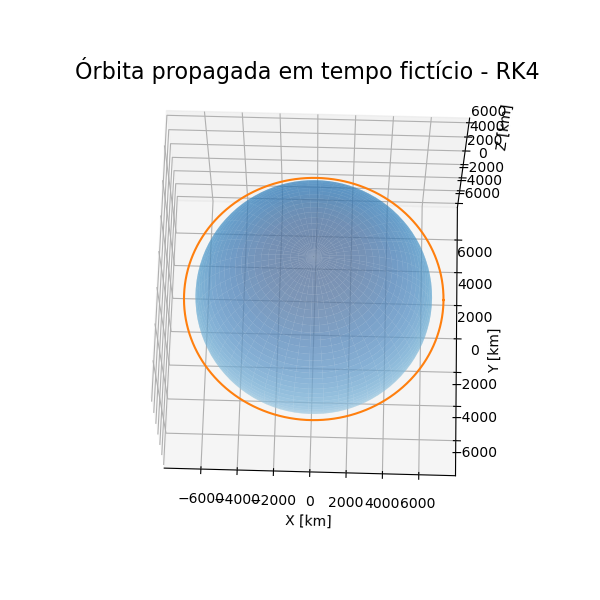

In [32]:
X = np.array(X_rk4)
V = np.array(V_rk4)
x1 = X[:, 0]
x2 = X[:, 1]
x3 = np.zeros(len(x1))
v1 = V[:, 0]
v2 = V[:, 1]
v3 = np.zeros(len(x1))
plotar_orbita_terra(x1, x2, x3, titulo = 'Órbita propagada em tempo fictício - RK4')

<IPython.core.display.Javascript object>


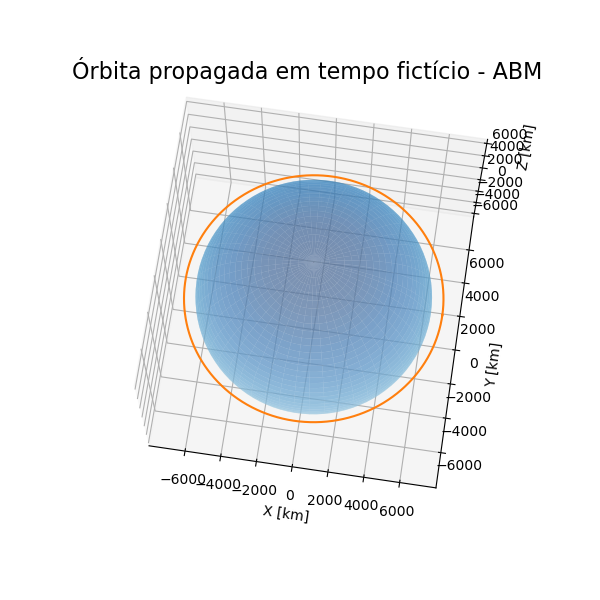

In [33]:
X = np.array(X_abm)
V = np.array(V_abm)
x1 = X[:, 0]
x2 = X[:, 1]
x3 = np.zeros(len(x1))
v1 = V[:, 0]
v2 = V[:, 1]
v3 = np.zeros(len(x1))
plotar_orbita_terra(x1, x2, x3, titulo = 'Órbita propagada em tempo fictício - ABM')

## Comparação

Nesta seção, os resultados deste trabalho serão comparados com os do trabalho 0 (T0) no último instante de integração. Os resultados do T0 são mostrados na célula a seguir.

In [34]:
# Resultados da lista 00 - ex. 4 para o instante final de integração
t_rk4_t0 = 5828.600000003673
x_rk4_t0 = np.array([6999.9999738826427347, 0.6046816007223892])
t_abm_t0 = 5828.600000003673
x_abm_t0 = np.array([6999.9990623670055356, 3.6231010835729522])

Os resultados deste trabalho (T3) são montados abaixo.

In [35]:
# Resultados deste trabalho
t_rk4 = T_rk4[-1]
x_rk4 = X_rk4[-1]
t_abm = T_abm[-1]
x_abm = X_abm[-1]

A função abaixo vai simplesmente gerar uma comparação entre os resultados dos dois trabalhos, no caso, uma diferença simples entre os pontos obtidos. 

In [36]:
# Comparação de resultados
def este_com_rel_a_este(xB, xA):
    return(xB - xA)

In [37]:
print('T3-tempo vs. T0-tempo | Diferença (x, y) = {} s'.format(este_com_rel_a_este(t_rk4, t_rk4_t0)))
print('T3-RK4 vs. T0-RK4 | Diferença (x, y) = {} km'.format(este_com_rel_a_este(x_rk4, x_rk4_t0)))
print('T3-RK4 vs. T0-ABM | Diferença (x, y) = {} km'.format(este_com_rel_a_este(x_rk4, x_abm_t0)))
print('T3-ABM vs. T0-RK4 | Diferença (x, y) = {} km'.format(este_com_rel_a_este(x_abm, x_rk4_t0)))
print('T3-ABM vs. T0-ABM | Diferença (x, y) = {} km'.format(este_com_rel_a_este(x_abm, x_abm_t0)))

T3-tempo vs. T0-tempo | Diferença (x, y) = 0.38128252075966884 s
T3-RK4 vs. T0-RK4 | Diferença (x, y) = [-9.11514113e-04  3.01841366e+00] km
T3-RK4 vs. T0-ABM | Diferença (x, y) = [ 1.52431312e-09 -5.81851958e-06] km
T3-ABM vs. T0-RK4 | Diferença (x, y) = [-9.11514135e-04  3.01841366e+00] km
T3-ABM vs. T0-ABM | Diferença (x, y) = [ 1.50248525e-09 -5.81838710e-06] km


As seguintes observações são feitas:

* As integrações numéricas nos dois trabalhos, para comparação, foi feita com passo de 1 $s$ e seu equivalente no tempo fictício. A diferença de tempo entre T3 e T0 foi de 0,39 $s$, aproximadamente.
* Com essa diferença final de tempo, foi obtida uma diferença máxima para a posição em $x$ que é da ordem de $9e(-4)$ e a mínima é de aproximadamente $1,5e(-9)$, com diferenças similares para os dois integradores.
* Na posição $y$, tanto o RK4 quanto o ABM do T3 tiveram a mesma diferença com relação ao RK4 do T0, que foi de aproximadamente 3 km. De maneira similar, tanto o RK4 quanto o ABM do T3 tiveram a mesma diferença com relação ao ABM do T0, que foi da ordem de $5e(-6)$ km em termos absolutos. 

Qualitativamente falando, a partir das observações, entende-se que os dois integradores do T3 tiveram desempenho similar, em termos de qualidade de resultados. Isso não pode ser dito dos mesmos integradores aplicados ao problema do T0, no qual o ABM teve desempenho superior ao RK4. Como os integradores são os mesmos e o que mudou de um trabalho para o outro foi o modelo dinâmico, conclui-se que a modelagem utilizada neste trabalho gera resultados mais consistentes que a utilizada no T0.

## Referências

KUGA, H. Notas de Aula da Disciplina Satélites Artificiais -  Movimento Orbital. Capítulo 6 - Métodos de Integração de Órbita. Instituto Nacional de Pesquisas Espaciais. 2021.